## Finals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
%matplotlib inline

Load data

In [2]:
# Load all football match data since 1872
data = pd.read_csv('international_matches.csv')
data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           23921 non-null  object 
 1   home_team                      23921 non-null  object 
 2   away_team                      23921 non-null  object 
 3   home_team_continent            23921 non-null  object 
 4   away_team_continent            23921 non-null  object 
 5   home_team_fifa_rank            23921 non-null  int64  
 6   away_team_fifa_rank            23921 non-null  int64  
 7   home_team_total_fifa_points    23921 non-null  int64  
 8   away_team_total_fifa_points    23921 non-null  int64  
 9   home_team_score                23921 non-null  int64  
 10  away_team_score                23921 non-null  int64  
 11  tournament                     23921 non-null  object 
 12  city                           23921 non-null 

In [4]:
# Format date
data['date'] = pd.to_datetime(data['date'])

In [5]:
data.columns

Index(['date', 'home_team', 'away_team', 'home_team_continent',
       'away_team_continent', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_team_score', 'away_team_score', 'tournament', 'city', 'country',
       'neutral_location', 'shoot_out', 'home_team_result',
       'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
       'home_team_mean_defense_score', 'home_team_mean_offense_score',
       'home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score'],
      dtype='object')

In [6]:
# Keep only relevent columns
data = data.drop(['home_team_continent',
       'away_team_continent','tournament', 'city', 'country',
       'neutral_location'], axis = 1)

In [7]:
fifa_rank = data[['date', 'home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank', 'away_team_total_fifa_points', 'home_team_total_fifa_points',
        ]]
home = data[['date', 'home_team', 'home_team_fifa_rank', 'home_team_total_fifa_points']].rename(columns={'home_team': 'team', 'home_team_fifa_rank': 'rank','home_team_total_fifa_points': 'rank_points'})
away = data[['date', 'away_team', 'away_team_fifa_rank', 'away_team_total_fifa_points']].rename(columns={'away_team': 'team', 'away_team_fifa_rank': 'rank', 
                                                                                                          'away_team_total_fifa_points':'rank_points'})
fifa_rank = home.append(away)
fifa_rank = fifa_rank.sort_values(['team', 'date'], ascending = [True, False])
fifa_rank['row_number'] = fifa_rank.groupby('team').cumcount()+1
# Look at 10 top teams
fifa_rank_top = fifa_rank[fifa_rank['row_number']==1].drop('row_number', axis = 1).nsmallest(10, 'rank')

In [8]:
fifa_rank_top

,date,team,rank,rank_points
23760,2022-06-06,Brazil,1,1832
23909,2022-06-14,Belgium,2,1827
23885,2022-06-13,France,3,1789
23741,2022-06-05,Argentina,4,1765
23906,2022-06-14,England,5,1761
23907,2022-06-14,Italy,6,1723
23866,2022-06-12,Spain,7,1709
23867,2022-06-12,Portugal,8,1674
23903,2022-06-14,Mexico,9,1658
23908,2022-06-14,Netherlands,10,1658


In [9]:
# Find columns with null values
col_with_nulls = [col for col in data.columns if data[col].isnull().any()]
for col in col_with_nulls:
    print(col)

home_team_goalkeeper_score
away_team_goalkeeper_score
home_team_mean_defense_score
home_team_mean_offense_score
home_team_mean_midfield_score
away_team_mean_defense_score
away_team_mean_offense_score
away_team_mean_midfield_score


In [10]:
# Teams in quarterfinals
teams_left = ['Korea Republic', 'Japan', 'Brazil', 'Spain', 'Switzerland', 'Croatia', 
              'Australia', 'USA', 'Argentina', 'Netherlands', 'Senegal', 'Poland', 'England', 'France', 'Morocco', 'Portugal',]

In [11]:
# Fill null values with mean
for i in teams_left:
    for j in col_with_nulls:
        data[j].fillna(data[data[j[0:9]]==i][j].mean(), inplace = True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           23921 non-null  datetime64[ns]
 1   home_team                      23921 non-null  object        
 2   away_team                      23921 non-null  object        
 3   home_team_fifa_rank            23921 non-null  int64         
 4   away_team_fifa_rank            23921 non-null  int64         
 5   home_team_total_fifa_points    23921 non-null  int64         
 6   away_team_total_fifa_points    23921 non-null  int64         
 7   home_team_score                23921 non-null  int64         
 8   away_team_score                23921 non-null  int64         
 9   shoot_out                      23921 non-null  object        
 10  home_team_result               23921 non-null  object        
 11  home_team_goalk

In [13]:
# Only look at recent games
recent = '2021-01-01'
cur_data = data[data['date']>recent]
# Remove date column
data.drop(['date'], axis = 1)
cur_data.head()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
22273,2021-01-12,United Arab Emirates,Iraq,74,69,1326,1347,0,0,No,Draw,71.000000,73.79646,65.200000,75.250694,68.000000,72.638938,74.884071,74.888496
22274,2021-01-18,Kuwait,Palestine,148,102,1060,1204,0,1,No,Lose,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496
22275,2021-01-19,Dominican Republic,Puerto Rico,159,179,1019,941,0,1,No,Lose,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496
22276,2021-01-22,Guatemala,Puerto Rico,131,179,1111,941,1,0,No,Win,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496
22277,2021-01-25,Dominican Republic,Serbia,159,30,1019,1495,0,0,No,Draw,73.888889,81.00000,72.652778,75.250694,75.195139,79.000000,80.000000,82.000000


In [14]:
# Find data relating to remaining teams
teams_left_data = cur_data[cur_data['home_team'].isin(teams_left)]
teams_left_data.head()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
22280,2021-01-31,USA,Trinidad and Tobago,22,103,1545,1201,7,0,No,Win,76.0,52.00000,75.5,76.7,75.2,72.638938,74.884071,74.888496
22298,2021-03-24,Portugal,Azerbaijan,5,108,1662,1180,1,0,No,Win,84.0,73.79646,83.8,84.3,85.2,72.638938,74.884071,61.200000
22300,2021-03-24,France,Ukraine,2,24,1755,1521,1,1,No,Draw,87.0,76.00000,85.5,86.7,87.0,76.000000,77.000000,79.800000
22319,2021-03-25,Japan,Korea Republic,27,38,1502,1465,3,0,No,Win,72.0,75.00000,75.5,75.7,76.8,72.500000,75.700000,77.000000
22321,2021-03-25,USA,Jamaica,22,47,1548,1437,4,1,No,Win,76.0,75.00000,75.5,76.7,75.2,71.500000,71.000000,69.000000


In [15]:
# Drop games that tied
binary_data = cur_data[cur_data['home_team_result'].isin(['Win', 'Lose'])]
binary_data.head()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
22274,2021-01-18,Kuwait,Palestine,148,102,1060,1204,0,1,No,Lose,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496
22275,2021-01-19,Dominican Republic,Puerto Rico,159,179,1019,941,0,1,No,Lose,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496
22276,2021-01-22,Guatemala,Puerto Rico,131,179,1111,941,1,0,No,Win,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496
22278,2021-01-27,Iraq,Kuwait,69,148,1347,1060,2,1,No,Win,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496
22280,2021-01-31,USA,Trinidad and Tobago,22,103,1545,1201,7,0,No,Win,76.000000,52.00000,75.500000,76.700000,75.200000,72.638938,74.884071,74.888496


In [16]:
# Create win column
def encode_win(x):
    if x == 'Win':
        return 1
    elif x == 'Draw':
        return -1
    else:
        return 0
win_col = binary_data['home_team_result'].transform(encode_win)
win_col

22274    0
22275    0
22276    1
22278    1
22280    1
        ..
23916    1
23917    0
23918    0
23919    0
23920    1
Name: home_team_result, Length: 1296, dtype: int64

In [17]:
binary_data['result'] = win_col

In [18]:
binary_data = binary_data.drop('home_team_result', axis=1)
binary_data.head()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,shoot_out,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,result
22274,2021-01-18,Kuwait,Palestine,148,102,1060,1204,0,1,No,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496,0
22275,2021-01-19,Dominican Republic,Puerto Rico,159,179,1019,941,0,1,No,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496,0
22276,2021-01-22,Guatemala,Puerto Rico,131,179,1111,941,1,0,No,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496,1
22278,2021-01-27,Iraq,Kuwait,69,148,1347,1060,2,1,No,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496,1
22280,2021-01-31,USA,Trinidad and Tobago,22,103,1545,1201,7,0,No,76.000000,52.00000,75.500000,76.700000,75.200000,72.638938,74.884071,74.888496,1


In [19]:
binary_data = binary_data.drop('shoot_out', axis=1)
binary_data = binary_data.drop('home_team_score', axis=1)
binary_data = binary_data.drop('away_team_score', axis=1)
binary_data.head()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,result
22274,2021-01-18,Kuwait,Palestine,148,102,1060,1204,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496,0
22275,2021-01-19,Dominican Republic,Puerto Rico,159,179,1019,941,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496,0
22276,2021-01-22,Guatemala,Puerto Rico,131,179,1111,941,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496,1
22278,2021-01-27,Iraq,Kuwait,69,148,1347,1060,73.888889,73.79646,72.652778,75.250694,75.195139,72.638938,74.884071,74.888496,1
22280,2021-01-31,USA,Trinidad and Tobago,22,103,1545,1201,76.000000,52.00000,75.500000,76.700000,75.200000,72.638938,74.884071,74.888496,1


In [20]:
# Split into x, y
x = binary_data.drop('result', axis=1)
x = x.drop('home_team', axis=1)
x = x.drop('away_team', axis=1)
x = x.drop('date', axis=1)
y = binary_data['result']

In [21]:
x.head()
feature_names = x.columns

In [22]:
y.head()

22274    0
22275    0
22276    1
22278    1
22280    1
Name: result, dtype: int64

In [23]:
# Split into training, testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=12)

Apply random forest algorithm

In [24]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train, y_train)

RandomForestRegressor()

In [25]:
# Get feature importances
rf.feature_importances_

array([0.17755489, 0.11653064, 0.13478589, 0.16157747, 0.03889485,
       0.0395033 , 0.04042138, 0.06107118, 0.03137355, 0.05741396,
       0.0589974 , 0.08187551])

<BarContainer object of 12 artists>

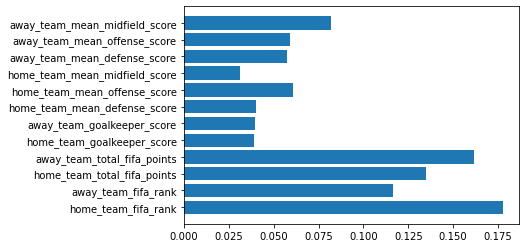

In [26]:
# Plot feature importances 
plt.barh(feature_names, rf.feature_importances_)

Apply logistic regression model

In [27]:
lr_model = LogisticRegression(random_state=16)
# Fit the LR model
lr_model.fit(x_train, y_train)

LogisticRegression(random_state=16)

In [28]:
# Get predictions for test set
y_pred = lr_model.predict(x_test)

In [29]:
# Determine accuracy
accuracy_score(y_test, y_pred)

0.7623456790123457

### Apply to round of 16 matchups

In [30]:
# Get most recent data for remaining teams
teams_left_data.sort_values(by='date', ascending=False)

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23920,2022-06-14,Korea Republic,Egypt,29,32,1519,1500,4,1,No,Win,75.0,73.79646,73.0,80.0,73.8,72.638938,79.300000,70.800000
23919,2022-06-14,Japan,Tunisia,23,35,1553,1499,0,3,No,Lose,73.0,73.79646,75.2,75.0,77.5,70.800000,72.300000,74.000000
23909,2022-06-14,Poland,Belgium,26,2,1544,1827,0,1,No,Lose,87.0,89.00000,75.2,84.7,75.8,80.800000,85.700000,85.500000
23908,2022-06-14,Netherlands,Wales,10,18,1658,1588,3,2,No,Win,81.0,74.00000,85.2,83.0,83.5,75.000000,73.000000,78.500000
23906,2022-06-14,England,Hungary,5,40,1761,1466,0,4,No,Lose,83.0,85.00000,85.0,88.0,84.0,75.500000,72.700000,73.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22319,2021-03-25,Japan,Korea Republic,27,38,1502,1465,3,0,No,Win,72.0,75.00000,75.5,75.7,76.8,72.500000,75.700000,77.000000
22335,2021-03-25,England,San Marino,4,210,1670,810,5,0,No,Win,82.0,73.79646,84.5,87.7,83.8,72.638938,74.884071,74.888496
22300,2021-03-24,France,Ukraine,2,24,1755,1521,1,1,No,Draw,87.0,76.00000,85.5,86.7,87.0,76.000000,77.000000,79.800000
22298,2021-03-24,Portugal,Azerbaijan,5,108,1662,1180,1,0,No,Win,84.0,73.79646,83.8,84.3,85.2,72.638938,74.884071,61.200000


In [31]:
# Get most recent data for each team
def get_team_stats(team, d):
    l = []
    for index, row in d.iterrows():
        if row['home_team'] == team:
            l = [row['home_team_fifa_rank'],row['home_team_total_fifa_points'], row['home_team_goalkeeper_score'],
                 row['home_team_mean_defense_score'],row['home_team_mean_offense_score'],row['home_team_mean_midfield_score']]
            return l
        if row['away_team'] == team:
            l = [row['away_team_fifa_rank'],row['away_team_total_fifa_points'], row['away_team_goalkeeper_score'],
                 row['away_team_mean_defense_score'],row['away_team_mean_offense_score'],row['away_team_mean_midfield_score']]
            return l            

In [32]:
# Create matchups
def matchup(home_stats, away_stats):
    l = []
    i = 0
    while i<6:
        l.append(home_stats[i])
        l.append(away_stats[i])
        i+=1
    return l

In [33]:
matches = [('Portugal','Switzerland'),('Argentina','Australia'),('Brazil','Korea Republic'),
        ('Croatia', 'Japan'), ('Netherlands', 'USA'), ('Morocco','Spain'),('France','Poland'),('England','Senegal')]

Run predictions

In [34]:
# Displaying out put model
def find_winner(home, away, stats):
    if lr_model.predict(stats) > 0:
        print(home)
    else:
        print(away)

In [35]:
for i in matches:
    d = pd.DataFrame([matchup(get_team_stats(i[0], teams_left_data.sort_values(by='date', ascending=False)), 
               get_team_stats(i[1], teams_left_data.sort_values(by='date', ascending=False)))])
    find_winner(i[0], i[1], d)

Portugal
Argentina
Brazil
Croatia
Netherlands
Spain
France
England


### Post matches accuracy: 0.875

### Apply to quarterfinals matchups

In [36]:
matches2 = [('Portugal','Morocco'),('Argentina','Netherlands'),('Brazil','Croatia'), ('France','England')]

In [37]:
for i in matches2:
    d = pd.DataFrame([matchup(get_team_stats(i[0], teams_left_data.sort_values(by='date', ascending=False)), 
               get_team_stats(i[1], teams_left_data.sort_values(by='date', ascending=False)))])
    find_winner(i[0], i[1], d)

Portugal
Argentina
Brazil
France


### Post matches accuracy: 0.5

## Apply to semifinals matchups

In [38]:
matches3 = [('France', 'Morocco'),('Argentina','Croatia')]

In [39]:
for i in matches3:
    d = pd.DataFrame([matchup(get_team_stats(i[0], teams_left_data.sort_values(by='date', ascending=False)), 
               get_team_stats(i[1], teams_left_data.sort_values(by='date', ascending=False)))])
    find_winner(i[0], i[1], d)

France
Argentina


### Post matches accuracy: 1.0

## Apply to finals matchups

In [40]:
matches4 = [('France', 'Argentina'),('Morocco','Argentina')]

In [41]:
for i in matches4:
    d = pd.DataFrame([matchup(get_team_stats(i[0], teams_left_data.sort_values(by='date', ascending=False)), 
               get_team_stats(i[1], teams_left_data.sort_values(by='date', ascending=False)))])
    find_winner(i[0], i[1], d)

France
Argentina
